In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from model import FeatureDependentMarkovChain
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 150)

# https://chadwick.readthedocs.io/en/latest/cwevent.html

In [3]:
state_to_id = {}
id_to_state = {}
i = 0
for outs in [0, 1, 2]:
    for r3 in [0, 1]:
        for r2 in [0, 1]:
            for r1 in [0, 1]:
                state_to_id[(outs, r1, r2, r3)] = i
                id_to_state[i] = (outs, r1, r2, r3)
                i += 1
state_to_id["INNING OVER"] = i
id_to_state[i] = "INNING OVER"

def func(x):
    outs = x.OUTS_CT
    r1 = 0 if isinstance(x.BASE1_RUN_ID, float) else 1
    r2 = 0 if isinstance(x.BASE2_RUN_ID, float) else 1
    r3 = 0 if isinstance(x.BASE3_RUN_ID, float) else 1
    return state_to_id[(outs, r1, r2, r3)]

n = len(state_to_id)

In [4]:
headtohead = pd.read_csv("data/headtohead-2017.csv")
batters = headtohead.groupby("RESP_BAT_ID").sum()
batter_features = batters.iloc[:,2:] / batters.B_PA[:, None]
pitchers = headtohead.groupby("RESP_PIT_ID").sum()
pitcher_features = pitchers.iloc[:,2:] / pitchers.B_PA[:, None]

In [5]:
df = pd.read_csv("data/all2018.csv")
df = df.join(batter_features, on='BAT_ID').join(pitcher_features, on='PIT_ID', lsuffix='_PIT')
df["STATE"] = df.apply(func, axis=1)
df["BAT_PIT_SAME"] = df.BAT_HAND_CD == df.PIT_HAND_CD
df["SCORE_DIFF"] = (df["BAT_HOME_ID"] * 2 - 1) * (df.HOME_SCORE_CT - df.AWAY_SCORE_CT)
df["DATE"] = pd.to_datetime(df.GAME_ID.str[3:-1], format="%Y%m%d")
df["STADIUM"] = df.GAME_ID.str[:3]
df["DOUBLEHEADER"] = df.GAME_ID.str[-1]
df.sort_values(by=["DATE", "STADIUM", "DOUBLEHEADER", "EVENT_ID"], inplace=True)
df["Inning_over"] = (df[["INN_CT", "BAT_HOME_ID"]].shift(1) != df[["INN_CT", "BAT_HOME_ID"]]).any(axis=1)
df.iloc[0, -1] = False
df.head(5)

/home/shane/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (64,65,85) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GAME_ID,AWAY_TEAM_ID,INN_CT,BAT_HOME_ID,OUTS_CT,BALLS_CT,STRIKES_CT,PITCH_SEQ_TX,AWAY_SCORE_CT,HOME_SCORE_CT,...,B_SH,B_SF,B_XI,STATE,BAT_PIT_SAME,SCORE_DIFF,DATE,STADIUM,DOUBLEHEADER,Inning_over
6267,ARI201803290,COL,1,0,0,2,2,BBFCS,0,0,...,0.004843,0.006053,0.0,0,True,0,2018-03-29,ARI,0,False
6268,ARI201803290,COL,1,0,1,2,2,CFBBX,0,0,...,0.004843,0.006053,0.0,8,False,0,2018-03-29,ARI,0,False
6269,ARI201803290,COL,1,0,1,2,0,BBX,1,0,...,0.004843,0.006053,0.0,8,False,1,2018-03-29,ARI,0,False
6270,ARI201803290,COL,1,0,1,1,2,SBCFC,1,0,...,0.004843,0.006053,0.0,9,False,1,2018-03-29,ARI,0,False
6271,ARI201803290,COL,1,0,2,0,2,SS>S,1,0,...,0.004843,0.006053,0.0,17,True,1,2018-03-29,ARI,0,False


In [6]:
features_df = df[['SCORE_DIFF', 'BAT_LINEUP_ID', 'BAT_HOME_ID', 'INN_CT', 'B_AB_PIT',
       'B_H_PIT', 'B_TB_PIT', 'B_2B_PIT', 'B_3B_PIT', 'B_HR_PIT', 'B_HR4_PIT',
       'B_RBI_PIT', 'B_BB_PIT', 'B_IBB_PIT', 'B_SO_PIT', 'B_GDP_PIT',
       'B_HP_PIT', 'B_SH_PIT', 'B_SF_PIT', 'B_XI_PIT', 'B_AB', 'B_H', 'B_TB',
       'B_2B', 'B_3B', 'B_HR', 'B_HR4', 'B_RBI', 'B_BB', 'B_IBB', 'B_SO',
       'B_GDP', 'B_HP', 'B_SH', 'B_SF', 'B_XI', 'BAT_HAND_CD', 'PIT_HAND_CD',
       'BAT_PIT_SAME']].copy()
features_df.INN_CT[features_df.INN_CT >= 10] = 10
features_df.SCORE_DIFF[features_df.SCORE_DIFF >= 3] = 3
features_df.SCORE_DIFF[features_df.SCORE_DIFF <= -3] = -3
dummy_cols = ["BAT_HAND_CD", "PIT_HAND_CD", "INN_CT", "BAT_LINEUP_ID", "SCORE_DIFF"]
for c in dummy_cols:
    features_df = pd.concat([features_df, pd.get_dummies(features_df[c], prefix=c)], axis=1)
features_df.drop(dummy_cols, axis=1, inplace=True)
features = features_df.values.astype(float)

/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load

In [7]:
# features_df = df[['BAT_LINEUP_ID']].copy()
# # features_df.INN_CT[features_df.INN_CT >= 10] = 10
# # features_df.SCORE_DIFF[features_df.SCORE_DIFF >= 3] = 3
# # features_df.SCORE_DIFF[features_df.SCORE_DIFF <= -3] = -3
# dummy_cols = ["BAT_LINEUP_ID"]
# for c in dummy_cols:
#     features_df = pd.concat([features_df, pd.get_dummies(features_df[c], prefix=c)], axis=1)
# features_df.drop(dummy_cols, axis=1, inplace=True)
# features = features_df.values

In [8]:
M = np.zeros((n, n))
R = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i == n-1:
            M[i, j] = 0 if j != n-1 else 1
        else:
            o_start, r1_start, r2_start, r3_start = id_to_state[i]
            if j == n-1:
                M[i, j] = 1 if o_start + r1_start + r2_start + r3_start + 1 >= 3 else 0
            else:
                o_end, r1_end, r2_end, r3_end = id_to_state[j]
                o = o_end - o_start
                r_start = r1_start + r2_start + r3_start
                r_end = r1_end + r2_end + r3_end
                runs = r_start - r_end + 1 - o
                runner_backwards = r3_start == 1 and r2_start == 0 and r1_start == 0 and r1_end == 1 and r2_end == 1
                M[i, j] = 1 if runs >= 0 and runs + o <= r_start + 1 and o >= 0 and not runner_backwards else 0
                R[i, j] = 0 if M[i, j] == 0 else runs
M.sum()

294.0

In [9]:
states = df["STATE"].values.copy()
lengths = np.diff(np.append(np.append(0, np.where(df["Inning_over"])[0]), df.shape[0])).copy()
i = 0
states_new = []
features_new = []
lengths_new = []
for l in lengths:
    if M[states[i:i+l][-1], 24] == 0: # game over early
        states_new += [states[i:i+l]]
        features_new += [features[i:i+l]]
        lengths_new += [l]
    else:
        states_new += [np.append(states[i:i+l], state_to_id["INNING OVER"])]
        features_new += [np.vstack([features[i:i+l], np.zeros((1, features.shape[1]))])]
        lengths_new += [l + 1]
    i += l
states = np.concatenate(states_new)
features = np.vstack(features_new)
lengths = np.array(lengths_new)

In [10]:
train_idx = int(lengths.size * .8)
val_idx = int(lengths.size * .9)

lengths_train = lengths[:train_idx]
lengths_val = lengths[train_idx:val_idx]
lengths_test = lengths[val_idx:]

states_train = states[:lengths_train.sum()]
states_val = states[lengths_train.sum():lengths_train.sum()+lengths_val.sum()]
states_test = states[lengths_train.sum()+lengths_val.sum():]

features_train = features[:lengths_train.sum()]
features_val = features[lengths_train.sum():lengths_train.sum()+lengths_val.sum()]
features_test = features[lengths_train.sum()+lengths_val.sum():]

# lengths_train = lengths_train[:5000]
# states_train = states_train[:sum(lengths_train)]
# features_train = features_train[:sum(lengths_train)]

# append some inning over sequences
states_train = np.append(states_train, [state_to_id["INNING OVER"]]*20)
lengths_train = np.append(lengths_train, 20)
features_train = np.vstack([features_train, np.zeros((20, features.shape[1]))])

In [11]:
features_train.shape, features_val.shape, features_test.shape

((187612, 64), (23482, 64), (23545, 64))

In [12]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler
ss = StandardScaler()

features_train = ss.fit_transform(features_train)
features_val = ss.transform(features_val)
features_test = ss.transform(features_test)

/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


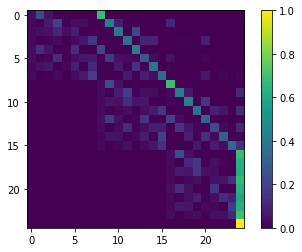

In [13]:
i = 0
P = np.zeros((25, 25))
for l in lengths:
    for j in range(i, i+l-1):
        if M[states[j], states[j+1]] == 0:
            print("ERROR")
            print (j, j+1)
        P[states[j], states[j+1]] += 1
    i += l
P = P / P.sum(axis=1)[:, None]
P[-1,:] = 0.
P[-1,-1] = 1.
plt.imshow(P, vmin=0, vmax=1)
plt.colorbar()
plt.savefig("figs/baseball_empirical.pdf")

In [14]:
(P > 0).sum(), M.sum()

(279, 294.0)

In [15]:
(P > 0).sum() / np.prod(P.shape)

0.4464

In [16]:
((P > 0) & ~(M > 0)).any()

False

In [17]:
M = P > 0

In [18]:
runs_list = []
atbats = []
for _ in range(1_000):
    state = 0
    runs = 0
    i = 1
    while True:
        outs, r1, r2, r3 = id_to_state[state]
        next_state = np.random.choice(np.arange(25), p=P[state])
        if id_to_state[next_state] == "INNING OVER":
            break
        runs += R[state, next_state]
        state = next_state
        i += 1
    atbats.append(i)
    runs_list.append(runs)

In [19]:
np.mean(atbats) * 9

39.96

0.673


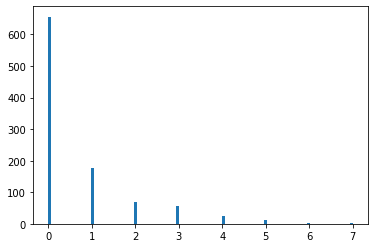

In [20]:
plt.hist(runs_list, bins=100);
print(np.mean(runs_list))

In [21]:
print("The second most probable transitions")
for i in range(25):
    print(id_to_state[i], id_to_state[np.argsort(P[i])[-2]], round(np.sort(P[i])[-2], 3))

The second most probable transitions
(0, 0, 0, 0) (0, 1, 0, 0) 0.231
(0, 1, 0, 0) (0, 1, 1, 0) 0.191
(0, 0, 1, 0) (1, 0, 0, 1) 0.226
(0, 1, 1, 0) (0, 1, 1, 1) 0.16
(0, 0, 0, 1) (1, 0, 0, 0) 0.207
(0, 1, 0, 1) (1, 1, 0, 0) 0.17
(0, 0, 1, 1) (1, 0, 0, 1) 0.148
(0, 1, 1, 1) (0, 1, 1, 1) 0.174
(1, 0, 0, 0) (1, 1, 0, 0) 0.231
(1, 1, 0, 0) (1, 1, 1, 0) 0.18
(1, 0, 1, 0) (2, 0, 0, 1) 0.163
(1, 1, 1, 0) (1, 1, 1, 1) 0.154
(1, 0, 0, 1) (2, 0, 0, 0) 0.199
(1, 1, 0, 1) (2, 1, 0, 0) 0.149
(1, 0, 1, 1) (1, 1, 1, 1) 0.191
(1, 1, 1, 1) (1, 1, 1, 1) 0.146
(2, 0, 0, 0) (2, 1, 0, 0) 0.237
(2, 1, 0, 0) (2, 1, 1, 0) 0.162
(2, 0, 1, 0) (2, 1, 1, 0) 0.156
(2, 1, 1, 0) (2, 1, 1, 1) 0.128
(2, 0, 0, 1) (2, 1, 0, 1) 0.155
(2, 1, 0, 1) (2, 0, 1, 1) 0.128
(2, 0, 1, 1) (2, 1, 1, 1) 0.183
(2, 1, 1, 1) (2, 1, 1, 1) 0.116
INNING OVER (1, 1, 1, 0) 0.0


In [22]:
model1 = FeatureDependentMarkovChain(n, lam_frob=0, mask=M, n_iter=1)
model1.fit(states_train, features_train*0, lengths_train, verbose=False)
train1, val1, test1 = model1.score(states_train, features_train*0, lengths_train, average=False), \
    model1.score(states_val, features_val*0, lengths_val, average=False), \
    model1.score(states_test, features_test*0, lengths_test, average=False)
train1, val1, test1

/home/shane/src/github.com/cvxgrp/mkvchain/model.py:308: RuntimeWarning: divide by zero encountered in log
  z = np.log(Ps[:, i, :])


(-147840.7743747866, -15071.111878079691, -14487.977533777637)

In [23]:
from copy import deepcopy
train2, val2, test2 = -np.inf, -np.inf, -np.inf
best_lam = None
model2 = None
for lam in np.logspace(-3,-1,10):
    model = FeatureDependentMarkovChain(n, lam_frob=lam, mask=M, n_iter=1)
    model.As = deepcopy(model1.As)
    model.bs = deepcopy(model1.bs)
    model.fit(states_train, features_train, lengths_train, verbose=False, warm_start=True)
    traini, vali, testi = model.score(states_train, features_train, lengths_train, average=False), \
          model.score(states_val, features_val, lengths_val, average=False), \
          model.score(states_test, features_test, lengths_test, average=False)
    if vali > val2:
        train2 = traini
        val2 = vali
        test2 = testi
        best_lam = lam
        model2 = model
train2, val2, test2

(-145456.79343146144, -15013.002357299538, -14412.361684193724)

In [24]:
model = FeatureDependentMarkovChain(n, lam_frob=best_lam, mask=M, n_iter=1)
model.As = deepcopy(model1.As)
model.bs = deepcopy(model1.bs)
model.fit(states_train, features_train, lengths_train, verbose=False, warm_start=True)

In [25]:
model.predict(features_train)

array([[[2.54118400e-02, 2.26631249e-01, 5.09128288e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.57215796e-02, 2.83765463e-04, 7.32242383e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.18108394e-02, 5.13765559e-02, 4.77967634e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.89034825e-01, 6.06714555e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.82041629e-02, 1.32766103e-01, 6.80820772e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.00000000e+00]],

       [[2.46484083e-02, 2.30759527e-01, 5.75518643e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.96723907e-02, 2.99663459e-04, 7.62812851e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.07895933e-02, 

In [26]:
for j in [0, 100, 200, 300]:
    print("\n\n", j)
    P = model.predict(features_train[j:j+1])[0]
    p = P[state_to_id[(0,1,0,0)]]
    for i in np.argsort(p)[-5:]:
        print(id_to_state[i], p[i])



 0
(1, 0, 1, 0) 0.06716628865083432
(0, 0, 1, 0) 0.07322423826272585
(2, 0, 0, 0) 0.09163860466345301
(0, 1, 1, 0) 0.20083942931811075
(1, 1, 0, 0) 0.439779071225554


 100
(1, 0, 1, 0) 0.06511321387524104
(0, 0, 1, 0) 0.06859931111067659
(2, 0, 0, 0) 0.08831620287377967
(0, 1, 1, 0) 0.19087327086425113
(1, 1, 0, 0) 0.4535040307425999


 200
(1, 0, 1, 0) 0.0675354408942779
(2, 0, 0, 0) 0.0747115607451427
(0, 0, 1, 0) 0.07971242826743766
(0, 1, 1, 0) 0.19078912841840662
(1, 1, 0, 0) 0.4555513610387755


 300
(0, 0, 1, 0) 0.06138181463442757
(2, 0, 0, 0) 0.09289461204069066
(1, 0, 1, 0) 0.14956043429474325
(0, 1, 1, 0) 0.2125938864583607
(1, 1, 0, 0) 0.3751551835705879


In [27]:
features_df.columns

Index(['BAT_HOME_ID', 'B_AB_PIT', 'B_H_PIT', 'B_TB_PIT', 'B_2B_PIT',
       'B_3B_PIT', 'B_HR_PIT', 'B_HR4_PIT', 'B_RBI_PIT', 'B_BB_PIT',
       'B_IBB_PIT', 'B_SO_PIT', 'B_GDP_PIT', 'B_HP_PIT', 'B_SH_PIT',
       'B_SF_PIT', 'B_XI_PIT', 'B_AB', 'B_H', 'B_TB', 'B_2B', 'B_3B', 'B_HR',
       'B_HR4', 'B_RBI', 'B_BB', 'B_IBB', 'B_SO', 'B_GDP', 'B_HP', 'B_SH',
       'B_SF', 'B_XI', 'BAT_PIT_SAME', 'BAT_HAND_CD_L', 'BAT_HAND_CD_R',
       'PIT_HAND_CD_L', 'PIT_HAND_CD_R', 'INN_CT_1', 'INN_CT_2', 'INN_CT_3',
       'INN_CT_4', 'INN_CT_5', 'INN_CT_6', 'INN_CT_7', 'INN_CT_8', 'INN_CT_9',
       'INN_CT_10', 'BAT_LINEUP_ID_1', 'BAT_LINEUP_ID_2', 'BAT_LINEUP_ID_3',
       'BAT_LINEUP_ID_4', 'BAT_LINEUP_ID_5', 'BAT_LINEUP_ID_6',
       'BAT_LINEUP_ID_7', 'BAT_LINEUP_ID_8', 'BAT_LINEUP_ID_9',
       'SCORE_DIFF_-3', 'SCORE_DIFF_-2', 'SCORE_DIFF_-1', 'SCORE_DIFF_0',
       'SCORE_DIFF_1', 'SCORE_DIFF_2', 'SCORE_DIFF_3'],
      dtype='object')

In [28]:
starting_state = state_to_id[(0,0,0,0)]
ending_state = state_to_id[(0,0,0,0)]
j = np.where(model.nonzero[starting_state] == ending_state)[0][0]
A, b = model.As[starting_state], model.bs[starting_state]
print("most positive effect", features_df.columns[np.argsort(A[:,j])[-5:]])
print("most negative effect", features_df.columns[np.argsort(A[:,j])[:5]])

most positive effect Index(['B_SO_PIT', 'B_BB_PIT', 'B_RBI_PIT', 'BAT_LINEUP_ID_4', 'B_HR_PIT'], dtype='object')
most negative effect Index(['INN_CT_10', 'B_SH_PIT', 'BAT_LINEUP_ID_9', 'B_3B_PIT',
       'BAT_LINEUP_ID_8'],
      dtype='object')


## With column norm regularization

In [29]:
model = FeatureDependentMarkovChain(n, lam_frob=0.0046, mask=M, n_iter=1, lam_col_norm=0.0045)
model.As = deepcopy(model1.As)
model.bs = deepcopy(model1.bs)
model.fit(states_train, features_train, lengths_train, verbose=False, warm_start=True)
train3, val3, test3 = model.score(states_train, features_train, lengths_train, average=False), \
    model.score(states_val, features_val, lengths_val, average=False), \
    model.score(states_test, features_test, lengths_test, average=False)
nnz = []
for i in range(model.As[0].shape[0]):
    col_norm = np.linalg.norm(np.concatenate([A[i,:] for A in model.As]))
    if col_norm > 0:
        nnz.append(i)
print(train3, val3, test3)
features_df.columns[nnz]

0 1.0 1.1976343473541569
1 1.2 1.1975774357113402
2 1.44 1.1975202948806896
3 1.728 1.1974641763351277
4 2.0736 1.197410270972685
5 2.48832 1.1973595862217634
6 2.9859839999999997 1.1973128806449236
7 3.5831807999999996 1.197270651791671
8 4.299816959999999 1.197233178144832
9 5.159780351999999 1.1972005878539826
10 6.191736422399999 1.1971729164428968
11 7.430083706879999 1.1971501251641945
12 8.916100448255998 1.197132075431848
13 10.699320537907196 1.197118479126248
14 12.839184645488634 1.1971088821513423
15 15.407021574586361 1.1971025924789618
16 18.48842588950363 1.1970988342514923
17 22.186111067404358 1.1970968311199455
18 26.62333328088523 1.197095900343922
19 31.947999937062274 1.1970955278566826
20 38.33759992447473 1.1970954044523285
21 11.501279977342419 1.197095374989699
22 13.801535972810901 1.197095356573695
23 16.56184316737308 1.1970953408415743
24 19.874211800847696 1.1970953283523285
25 11.924527080508618 1.1970953172048528
26 14.309432496610341 1.197095308787631
2

Index(['B_HR_PIT', 'B_BB_PIT', 'B_SO_PIT', 'B_SH_PIT', 'B_3B', 'INN_CT_9',
       'BAT_LINEUP_ID_1', 'BAT_LINEUP_ID_9', 'SCORE_DIFF_-3'],
      dtype='object')

In [30]:
nnz = np.array(nnz)

In [31]:
train4, val4, test4 = -float("inf"), -float("inf"), -float("inf")
for lam in np.logspace(-3,-1,10):
    model = FeatureDependentMarkovChain(n, lam_frob=0.0046, mask=M, n_iter=1)
    model.fit(states_train, features_train[:,nnz], lengths_train, verbose=False, warm_start=False)
    traini, vali, testi = model.score(states_train, features_train[:,nnz], lengths_train, average=False), \
        model.score(states_val, features_val[:,nnz], lengths_val, average=False), \
        model.score(states_test, features_test[:,nnz], lengths_test, average=False)
    if vali > val4:
        train4 = traini
        val4 = vali
        test4 = testi
train4, val4, test4

(-146947.37282030468, -15010.968129790797, -14413.498221633326)

In [32]:
print("Empirical & %.2f & %.2f & %.2f \\\\" % (train1, val1, test1))
print("Feature-dependent sum of squares & %.2f & %.2f & %.2f \\\\" % (train2, val2, test2))
print("Feature-dependent column norm & %.2f & %.2f & %.2f \\\\" % (train3, val3, test3))
print("Feature-dependent subset features & %.2f & %.2f & %.2f \\\\" % (train4, val4, test4))

Empirical & -147840.77 & -15071.11 & -14487.98 \\
Feature-dependent sum of squares & -145456.79 & -15013.00 & -14412.36 \\
Feature-dependent column norm & -147588.87 & -15054.21 & -14463.16 \\
Feature-dependent subset features & -146947.37 & -15010.97 & -14413.50 \\


## Fictitious simulation

In [33]:
# https://www.espn.com/mlb/game?gameId=380403126

In [34]:
# Seattle Mariners: David Frietas (batter), and Marco Gonzales (pitcher)
# SF Giants: Buster Posey (batter), and Tyson Blach (pitcher)

In [35]:
df[(df.GAME_ID == "SFN201804030") & (df.BAT_HOME_ID == 0) & (df.BAT_LINEUP_ID == 8)]

,GAME_ID,AWAY_TEAM_ID,INN_CT,BAT_HOME_ID,OUTS_CT,BALLS_CT,STRIKES_CT,PITCH_SEQ_TX,AWAY_SCORE_CT,HOME_SCORE_CT,...,B_SH,B_SF,B_XI,STATE,BAT_PIT_SAME,SCORE_DIFF,DATE,STADIUM,DOUBLEHEADER,Inning_over
152758,SFN201804030,SEA,1,0,2,0,0,1X,4,0,...,0.014451,0.007225,0.0,17,False,4,2018-04-03,SFN,0,False
152777,SFN201804030,SEA,4,0,0,0,0,X,4,0,...,0.014451,0.007225,0.0,1,False,4,2018-04-03,SFN,0,False
152790,SFN201804030,SEA,5,0,2,3,2,*BCBCFB*B,6,1,...,0.000000,0.000000,0.0,19,True,5,2018-04-03,SFN,0,False
152811,SFN201804030,SEA,8,0,0,0,2,.TFS,6,3,...,0.003846,0.000000,0.0,0,True,3,2018-04-03,SFN,0,True


In [56]:
f_seattle_batting = features_df.loc[152758].astype(float).copy()
f_giants_batting = features_df.loc[152766].astype(float).copy()

In [57]:
f_seattle_batting_1 = features_df.loc[152831].astype(float).copy()
f_giants_batting_1 = features_df.loc[152845].astype(float).copy()

In [71]:
def simulate_game(f_seattle_batting, f_giants_batting, verbose=False):
    inning = 1
    top = True
    runs_seattle = 0
    runs_giants = 0
    while True:
        # simulate an inning
        if top:
            if verbose:
                print("Seattle batting")
            state = 0
            f_seattle_batting[['INN_CT_1', 'INN_CT_2', 'INN_CT_3',
                   'INN_CT_4', 'INN_CT_5', 'INN_CT_6', 'INN_CT_7', 'INN_CT_8', 'INN_CT_9',
                   'INN_CT_10']] = 0.
            f_seattle_batting['INN_CT_%d' % min(inning, 10)] = 1.
            if verbose:
                print(id_to_state[state])
            while state != 24:
                f_seattle_batting[['SCORE_DIFF_-2', 'SCORE_DIFF_-1', 'SCORE_DIFF_0',
                       'SCORE_DIFF_1', 'SCORE_DIFF_2', 'SCORE_DIFF_3']] = 0.
                f_seattle_batting['SCORE_DIFF_%d' % max(min(runs_seattle - runs_giants, 3), -3)] = 1.
                P = model2.predict(ss.transform(f_seattle_batting[None,:]))[0]
                new_state = np.random.choice(np.arange(25), p=P[state,:])
                runs_seattle += int(R[state, new_state])
                if verbose:
                    print(id_to_state[state], int(R[state, new_state]))
                state = new_state
            top = False
        else:
            if verbose:
                print("Giants batting")
            state = 0
            f_giants_batting[['INN_CT_1', 'INN_CT_2', 'INN_CT_3',
                   'INN_CT_4', 'INN_CT_5', 'INN_CT_6', 'INN_CT_7', 'INN_CT_8', 'INN_CT_9',
                   'INN_CT_10']] = 0.
            f_giants_batting['INN_CT_%d' % min(inning, 10)] = 1.
            if verbose:
                print(id_to_state[state])
            while state != 24:
                f_giants_batting[['SCORE_DIFF_-2', 'SCORE_DIFF_-1', 'SCORE_DIFF_0',
                       'SCORE_DIFF_1', 'SCORE_DIFF_2', 'SCORE_DIFF_3']] = 0.
                f_giants_batting['SCORE_DIFF_%d' % max(min(runs_giants - runs_seattle, 3), -3)] = 1.
                P = model2.predict(ss.transform(f_giants_batting[None,:]))[0]
                new_state = np.random.choice(np.arange(25), p=P[state,:])
                runs_giants += int(R[state, new_state])
                if verbose:
                    print(id_to_state[state], int(R[state, new_state]))
                state = new_state
            top = True
        inning += 1
        
        # the game is over
        if inning >= 10 and runs_seattle != runs_giants:
            break
        
    return runs_seattle, runs_giants

In [79]:
np.random.seed(0)
import tqdm
scores = []
for _ in tqdm.tqdm(range(10000)):
    scores.append(simulate_game(f_seattle_batting, f_giants_batting))
x = np.array(scores)
(x[:,1] > x[:,0]).mean()

100%|██████████| 10000/10000 [09:09<00:00, 18.19it/s]


0.5338

In [80]:
(x[:,1] > x[:,0]).mean(), (x[:,1] - x[:,0]).mean()

(0.5338, 0.2202)

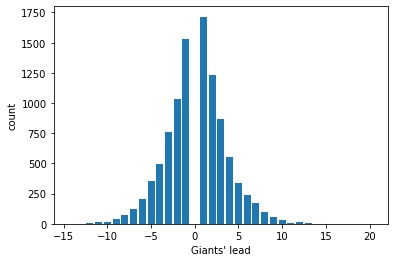

In [81]:
q = pd.value_counts(x[:,1] - x[:,0])
plt.bar(q.index, q)
plt.xlabel("Giants' lead")
plt.ylabel("count")
plt.savefig("figs/baseball_lead_giants.pdf")

In [82]:
np.random.seed(0)
import tqdm
scores = []
for _ in tqdm.tqdm(range(10000)):
    scores.append(simulate_game(f_seattle_batting_1, f_giants_batting_1))
x = np.array(scores)
(x[:,1] > x[:,0]).mean(), (x[:,1] - x[:,0]).mean()

100%|██████████| 10000/10000 [09:00<00:00, 18.49it/s]


(0.3851, -0.9374)

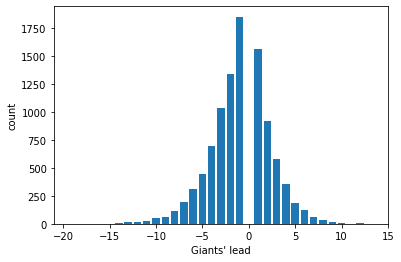

In [83]:
q = pd.value_counts(x[:,1] - x[:,0])
plt.bar(q.index, q)
plt.xlabel("Giants' lead")
plt.ylabel("count")
plt.savefig("figs/baseball_lead_mariners.pdf")